## Function Approximation with Sparse Regression

In this tutorial, we demonstrate how to approximate a function with sparse regression by constructing a Polynomial Chaos (PC) surrogate with Bayesian compressive sensing (BCS). The function we will approximate here is the Genz Oscillatory function, defined as:

\begin{align}f(x) = \cos\left(2 \pi s + \sum_{i=1}^d w_i x_i\right)\end{align}

Where:

- $s$: The shift parameter (``self.shift`` in the class).
- $w_i$: The weights for each dimension (``self.weights`` in the class).
- $x_i$: The input variables.
- $d$: The dimensionality of the input $x$ (number of components in $x$).

Through three different build processes, we will construct three PC surrogates to highlight the advantages of BCS and explore the effects of the `eta` hyperparameter on model results. First, we'll build with least squares regression to demonstrate the limitations of non-sparse methods and the need for BCS. Then we'll build with BCS using a given eta of $1 \times 10^{-10}$ and identify aspects for model improvement. Last, we'll build with the most optimal eta, as found through cross-validation algorithms exposed here. All three surrogates will be evaluated on testing and training data, with parity plots and Root Mean Square Error (RMSE) values used to compare their performance. 

To follow along with the cross-validation algorithm used to select the optimal eta, see section "Functions for cross-validation algorithm" in the second half of the notebook.

In [1]:
import os
import sys

import numpy as np
import copy
import math
import pytuq.utils.funcbank as fcb
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error

from pytuq.surrogates.pce import PCE
from pytuq.utils.maps import scaleDomTo01
from pytuq.func.genz import GenzOscillatory

# Constructing PC surrogate and generating data

To start, we begin with defining our true model and input parameters for our PC surrogate.

After importing GenzOscillatory from ``pytuq.func.genz``, we generate the Genz function below, along with training data and testing data with output noise. This data and the corresponding Genz function will be used to create the same PC surrogate fitted in all three examples: first with linear regression, next using BCS with a given eta, and third using BCS with the most optimal eta. 

In [2]:
# Random number generator
from scipy.stats import qmc
rng_seed = 43

In [ ]:
# Define our true model as the Genz Oscillatory function in multiple dimensions
func_dim = 4
func_weights = [1.0/(i+1)**2 for i in range(func_dim)] 
func = GenzOscillatory(shift=0.25, weights=func_weights)
noise_std = 0.025

rng = qmc.LatinHypercube(d=func_dim, seed=rng_seed)
np.random.seed(42)

# As we choose to use Legendre polynomials later in the surrogate construction, we define the domain of ξ on [-1, 1]^d
ksi_domain = np.array([[-1.0, 1.0]] * func_dim)  

# Training data
n_trn = 70
value_ksi_trn = 2*rng.random(n=n_trn) - 1            # Randomly generating 70 data points within the domain of ξ 
x_trn = scaleDomTo01(value_ksi_trn, ksi_domain)      # We scale our training data to [0, 1]^d, the domain of the Genz function
y_trn = func(x_trn) + np.random.normal(0, noise_std, size = (n_trn, 1))

# Testing data
n_tst = 10000
value_ksi_tst = 2*rng.random(n=n_tst) - 1 
x_tst = scaleDomTo01(value_ksi_tst, ksi_domain)
y_tst = func(x_tst)

With a stochastic dimensionality of 4 (defined above) and a chosen polynomial order of 4, we construct the PC surrogate that will be used in both builds. By calling the `printInfo()` method from the PCRV variable, you can print the PC surrogate's full basis and current coefficients, before BCS selects and retains the most significant PC terms to reduce the basis.

In [4]:
# (1) Construct a PC surrogate
order = 4
pce_surr = PCE(func_dim, order, 'LU', verbose = 1)

# Optional verbosity output:
print("Full Basis and Current Coefficients:")
pce_surr.pcrv.printInfo()
print("Number of Basis Terms:", pce_surr.get_pc_terms())

# (1.5) Set training data
pce_surr.set_training_data(value_ksi_trn[:80], y_trn[:80,0])

Constructed PC Surrogate with the following attributes:
['LU', 'LU', 'LU', 'LU'] PC Random Variable(pdim=1, sdim=4)

Full Basis and Current Coefficients:
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 1 1]
 [0 0 0 2]
 [3 0 0 0]
 [2 1 0 0]
 [2 0 1 0]
 [2 0 0 1]
 [1 2 0 0]
 [1 1 1 0]
 [1 1 0 1]
 [1 0 2 0]
 [1 0 1 1]
 [1 0 0 2]
 [0 3 0 0]
 [0 2 1 0]
 [0 2 0 1]
 [0 1 2 0]
 [0 1 1 1]
 [0 1 0 2]
 [0 0 3 0]
 [0 0 2 1]
 [0 0 1 2]
 [0 0 0 3]
 [4 0 0 0]
 [3 1 0 0]
 [3 0 1 0]
 [3 0 0 1]
 [2 2 0 0]
 [2 1 1 0]
 [2 1 0 1]
 [2 0 2 0]
 [2 0 1 1]
 [2 0 0 2]
 [1 3 0 0]
 [1 2 1 0]
 [1 2 0 1]
 [1 1 2 0]
 [1 1 1 1]
 [1 1 0 2]
 [1 0 3 0]
 [1 0 2 1]
 [1 0 1 2]
 [1 0 0 3]
 [0 4 0 0]
 [0 3 1 0]
 [0 3 0 1]
 [0 2 2 0]
 [0 2 1 1]
 [0 2 0 2]
 [0 1 3 0]
 [0 1 2 1]
 [0 1 1 2]
 [0 1 0 3]
 [0 0 4 0]
 [0 0 3 1]
 [0 0 2 2]
 [0 0 1 3]
 [0 0 0 4]] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

From the input parameters of our PC surrogate, we have 70 basis terms in our PCE. With 70 training points and no noise, having 70 basis terms would mean that we have a fully determined system, as the number of training points is the same as the number of basis terms. However, with the addition of noise in our training data, it becomes harder for the model to accurately fit all basis terms, leading to potential overfitting. This demonstrates the helpful role BCS might play as a choice for our regression build. As a sparse regression approach, BCS uses regularization to select only the most relevant basis terms, making it particularly effective in situations like this, where we do not have enough clear information to fit all basis terms without overfitting.

In the next sections, we will explore the effects of overfitting in more detail.


# Least Squares Regression

To start, we call the PCE class method of `build()` with no arguments to use the default regression option of least squares. Then, through `evaluate()`, we can generate model predictions for our training and testing data.

In [5]:
# (2) Build the linear regression object for fitting
pce_surr.build()

# (3) Evaluate the PC model
y_trn_approx = pce_surr.evaluate(value_ksi_trn)
y_tst_approx = pce_surr.evaluate(value_ksi_tst)


Regression method: lsq


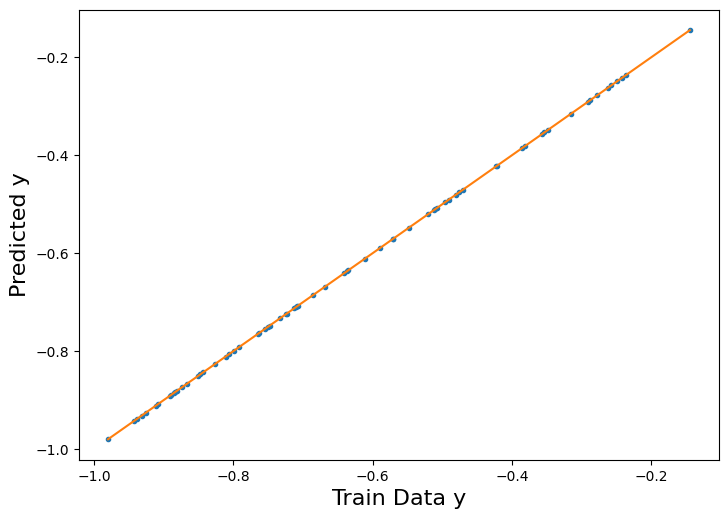

In [6]:
# Plot the surrogate model's output vs. the training data output
y_trn_mM = [y_trn[:,0].min(),y_trn[:,0].max()]

fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_axes([0.15, 0.15, 0.80, 0.75])

ax1.plot(y_trn[:,0],y_trn_approx["Y_eval"],".")
ax1.plot(y_trn_mM,y_trn_mM) # Diagonal line

ax1.set_xlabel("Train Data y", size=16)
ax1.set_ylabel("Predicted y", size=16); 

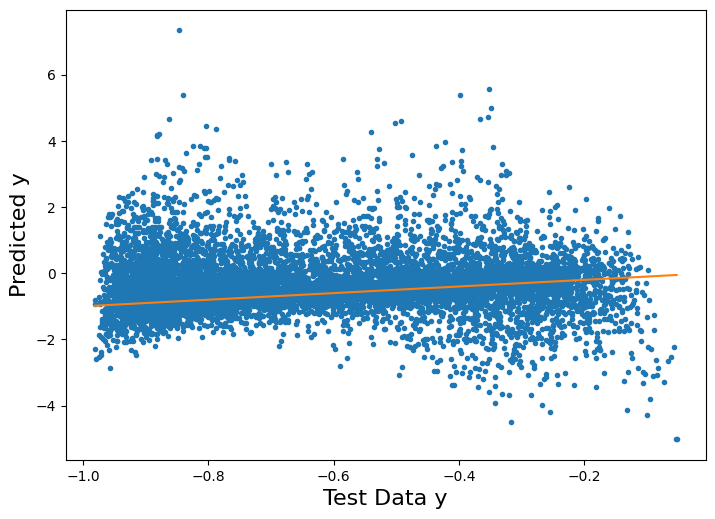

In [7]:
# Plot the surrogate model's output vs. the testing data output

y_tst_mM = [y_tst[:,0].min(),y_tst[:,0].max()]


fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_axes([0.15, 0.15, 0.80, 0.75])


ax2.plot(y_tst[:,0],y_tst_approx["Y_eval"],".")
ax2.plot(y_tst_mM,y_tst_mM) # Diagonal line

ax2.set_xlabel("Test Data y", size=16)
ax2.set_ylabel("Predicted y", size=16); 

In [8]:
# Evaluate goodness of fit with RMSE
rmse_trn = root_mean_squared_error(y_trn[:,0],y_trn_approx["Y_eval"])
print("The training RMSE in the PCE LSQ approximation is %.2e"%rmse_trn)

rmse_tst = root_mean_squared_error(y_tst[:,0],y_tst_approx["Y_eval"])
print("The testing RMSE in the PCE LSQ approximation is %.2e"%rmse_tst)

The training RMSE in the PCE LSQ approximation is 1.91e-15
The testing RMSE in the PCE LSQ approximation is 9.22e-01


The results above show us the limitations of using least squares regression to construct our surrogate. From the parity plots, we can see how the testing predictions from the LSQ regression are more spread out from the parity line, while the training predictions are extremely close to the line. Because LSQ fits all the basis terms to the training data, the model fits too closely to the noisy training dataset, and the true underlying pattern of the function is not effectively captured. Our RMSE values align with this as well: while the training RMSE is extremely low, the testing RMSE is significantly higher, as the model struggles to generalize to the unseen test data. 

To improve our model's generalization, we can build our model with BCS instead. As a sparse regression method, BCS reduces the number of basis terms with which we can fit our data to, reducing the risk of overfitting. 

# BCS with default settings (default eta)

In this section, we use the same PC surrogate, `pce_surr`, for the second build. With the flag `regression='bcs'`, we choose the BCS method for the fitting. A user-defined eta of 1e-10 is also passed in.

In [9]:
# (2) Build the linear regression object for fitting
pce_surr.build(regression='bcs', eta=1.e-10)

# Optional verbosity output:
print("Retained Basis and Coefficients:")
pce_surr.pcrv.printInfo()
print("Number of retained basis terms:", pce_surr.get_pc_terms())

Regression method: bcs
Retained Basis and Coefficients:
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [2 0 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [2 1 0 0]
 [0 4 0 0]
 [0 0 3 0]
 [2 0 2 0]
 [1 0 0 2]
 [2 1 1 0]
 [1 0 2 0]
 [1 2 1 0]
 [1 2 0 1]
 [1 0 0 3]] [-0.62694767 -0.37426547 -0.08797315 -0.02795855  0.04176134 -0.03783695
  0.01375504  0.02559825 -0.01616989 -0.01758198 -0.02274328  0.01132392
 -0.01835694 -0.00490663 -0.00938681 -0.00898039  0.00175116]
Number of retained basis terms: [17]


After fitting, we evaluate the PCE using our training and testing data. To analyze the model's goodness of fit, we first plot the surrogate predictions against the training and testing data respectively.

In [10]:
# (3) Evaluate the PC model
y_trn_approx = pce_surr.evaluate(value_ksi_trn)
y_tst_approx = pce_surr.evaluate(value_ksi_tst)

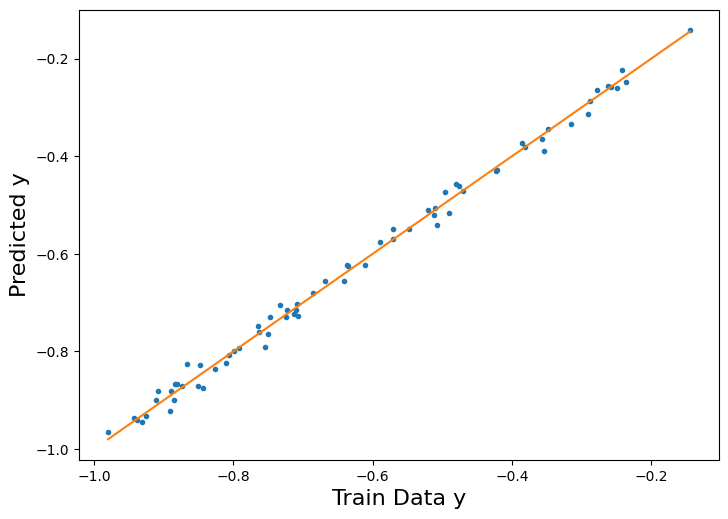

In [11]:
# Plot the surrogate model's output vs. the training data output
y_trn_mM = [y_trn[:,0].min(),y_trn[:,0].max()]

fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_axes([0.15, 0.15, 0.80, 0.75])

ax1.plot(y_trn[:,0],y_trn_approx["Y_eval"],".")
ax1.plot(y_trn_mM,y_trn_mM) # Diagonal line

ax1.set_xlabel("Train Data y", size=16)
ax1.set_ylabel("Predicted y", size=16); 

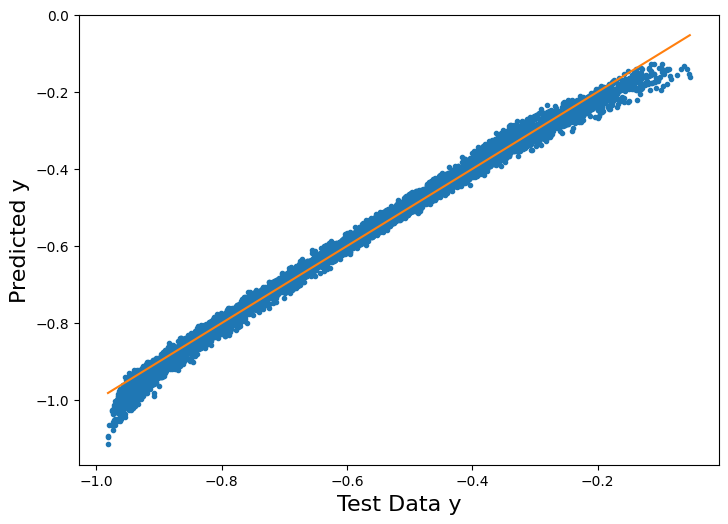

In [12]:
# Plot the surrogate model's output vs. the testing data output

y_tst_mM = [y_tst[:,0].min(),y_tst[:,0].max()]


fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_axes([0.15, 0.15, 0.80, 0.75])


ax2.plot(y_tst[:,0],y_tst_approx["Y_eval"],".")
ax2.plot(y_tst_mM,y_tst_mM) # Diagonal line

ax2.set_xlabel("Test Data y", size=16)
ax2.set_ylabel("Predicted y", size=16); 

In [13]:
# Evaluate goodness of fit with RMSE
rmse_trn = root_mean_squared_error(y_trn[:,0],y_trn_approx["Y_eval"])
print("The training RMSE in the PCE BCS approximation is %.2e"%rmse_trn)

rmse_tst = root_mean_squared_error(y_tst[:,0],y_tst_approx["Y_eval"])
print("The testing RMSE in the PCE BCS approximation is %.2e"%rmse_tst)

The training RMSE in the PCE BCS approximation is 1.62e-02
The testing RMSE in the PCE BCS approximation is 1.80e-02


From our parity plots, we can see how BCS already generalizes better to unseen data as compared to LSQ, with reduced error in our testing data predictions. In our RMSE calculations, notice how the training erorr is smaller than the testing error. Though the difference in value is small, this amount is still significant as we have noise in our training data yet no noise in our testing data. That the testing error is higher than the training error suggests that overfitting is still happening within our model. 

In the next section, we explore how finding the optimal value of eta -- the stopping criterion for the BCS parameter of gamma, determined through a Bayesian evidence maximization approach -- can impact model sparsity and accuracy to avoid overfitting.

# BCS with optimal eta (found through cross-validation) 

Before we build our PC surrogate again with the most optimal eta, we first expose the cross-validation algorithm `optimize_eta` and its two helper functions, `kfold_split` and `kfold_cv` below. These functions have been implemented under-the-hood in the PCE surrogate class, but for the purposes of this tutorial, you may find it useful to follow along with the K-fold cross-validation method used to find the most optimal eta (the eta with the lowest validation RMSE across all of its folds).

### Functions for cross-validation algorithm

In [14]:
def kfold_split(nsamples,nfolds,seed=13):
    """
    Return dictionary of training and testing pairs using k-fold cross-validation.

    Args:
        nsamples (int): Total number of training samples.
        nfolds (int): Number of folds to use for k-fold cross-validation.
        seed (int, optional): Random seed for reproducibility. Defaults to 13.

    Returns:
        dict: A dictionary where each key is the fold number (0 to nfolds-1) 
        and each value is a dictionary with:
            - "train index" (np.ndarray): Indices of training samples.
            - "val index" (np.ndarray): Indices of validation samples.
    """
    # Returns split data where each data is one fold left out
    KK=nfolds
    rn = np.random.RandomState(seed)

    # Creating a random permutation of the samples indices list
    indp=rn.permutation(nsamples)

    # Split the permuted indices into KK (or # folds) equal-sized chunks 
    split_index=np.array_split(indp,KK)

    # Dictionary to hold the indices of the training and validation samples
    cvindices = {}

    # create testing and training folds
    for j in range(KK):
        # Iterating through the number of folds
        fold = j
        # Iterate through # folds, if i != fold number, 
        newindex = [split_index[i] for i in range(len(split_index)) if i != (fold)]
        train_ind = np.array([],dtype='int64')
        for i in range(len(newindex)): train_ind = np.concatenate((train_ind,newindex[i]))
        test_ind = split_index[fold]
        cvindices[j] = {'train index': train_ind, 'val index': test_ind}

    return cvindices

In [15]:
def kfold_cv(x,y,nfolds=3,seed=13):
    """
    Splits data into training/testing pairs for kfold cross-val
    x is a data matrix of size n x d1, d1 is dim of input
    y is a data matrix of size n x d2, d2 is dim of output

    Args:
    x (np.ndarray): 
        Input matrix with shape (n, d1) or 1D array with shape (n,).
        Each row is a sample; columns are input features.
    y (np.ndarray):
        Target array with shape (n,) for single-output, or (n, d2) for
        multi-output. If 1D, it is internally reshaped to (n, 1) before
        slicing; outputs are `np.squeeze`d per fold.
    nfolds (int, optional): Number of folds for cross-validation. Defaults to 3.
    seed (int, optional):
        Random seed for reproducible shuffling in `kfold_split`. Defaults to 13.
    """
    if len(x.shape)>1:
        n,d1 = x.shape
    else:
        n=x.shape
    ynew = np.atleast_2d(y)
    if len(ynew) == 1: ynew = ynew.T # change to shape (n,1)
    _,d2 = ynew.shape
    cv_idx = kfold_split(n,nfolds,seed)

    kfold_data = {}
    for k in cv_idx.keys():
        kfold_data[k] = {
        'xtrain': x[cv_idx[k]['train index']],
        'xval': x[cv_idx[k]['val index']],
        'ytrain': np.squeeze(ynew[cv_idx[k]['train index']]),
        'yval': np.squeeze(ynew[cv_idx[k]['val index']])
        } # use squeeze to return 1d array

        # set train and test to the same if 1 fold
        if nfolds == 1:
            kfold_data[k]['xtrain'] = kfold_data[k]['xval']
            kfold_data[k]['ytrain'] = kfold_data[k]['yval']

    return kfold_data

In [16]:
def optimize_eta(pce, etas, nfolds, verbose=0, plot=False):
    """
    Choose the optimum eta for Bayesian compressive sensing. Calculates the RMSE
        for each eta for a specified number of folds. Selects the eta with the lowest
        RMSE after averaging the RMSEs over the folds.

    Input:
        y:             1D numpy array (vector) with function, evaluated at the
                            sample points [#samples,]
        x:             N-dimensional NumPy array with sample points [#samples,
                            #dimensions]
        etas:          NumPy array or list with the threshold for stopping the
                            algorithm. Smaller values retain more nonzero
                            coefficients
        verbose:       Flag for print statements
        plot:          Flag for whether to generate a plot for eta optimization

    Output:
        eta_opt:      Optimum eta

    """
    # Split data in k folds -> Get dictionary of data split in training + testing folds
    kfold_data = kfold_cv(pce._x_train, pce._y_train, nfolds)

    # Each value has data for 1 fold. Each value is a list of the RMSEs for each possible eta in the fold. 
    RMSE_list_per_fold_tr = [] 

    # Same but for testing data
    RMSE_list_per_fold_test = []

    # Make a copy of the PCE object to run the cross-validation algorithm on
    pce_copy = copy.deepcopy(pce)
    pce_copy.verbose = 0

    # Loop through each fold
    for i in range(nfolds):

        # Get the training and validation data
        x_tr = kfold_data[i]['xtrain']
        y_tr = kfold_data[i]['ytrain']
        x_test = kfold_data[i]['xval']
        y_test = kfold_data[i]['yval']
        
        # As we conduct BCS for this fold with each separate eta, the RMSEs will be added to these lists
        RMSE_per_eta_tr = [] 
        RMSE_per_eta_test = [] 

        # Set the x and y training data for the copied PCE object
        pce_copy.set_training_data(x_tr, y_tr)

        # Loop through each eta
        for eta in etas:

            # Conduct the BCS fitting. The object is automatically updated with new multiindex and coefficients received from the fitting.
            cfs = pce_copy.build(regression = 'bcs', eta=eta)

            # Evaluate the PCE object at the training and validation points 
            y_tr_eval = (pce_copy.evaluate(x_tr))['Y_eval']
            y_test_eval = (pce_copy.evaluate(x_test))['Y_eval']

            # Print statement for verbose flag
            if verbose > 1:
                print("Fold " + str(i + 1) + ", eta " + str(eta) + ", " + str(len(cfs)) + " terms retained out of a full basis of size " + str(len(pce.pcrv.mindices[0])))
            
            # Calculate the RMSEs for the training and validation points.
            # Append the values into the list of etas per fold.
            MSE = np.square(np.subtract(y_tr, y_tr_eval)).mean()
            RMSE = math.sqrt(MSE)
            RMSE_per_eta_tr.append(RMSE)

            MSE = np.square(np.subtract(y_test, y_test_eval)).mean()
            RMSE = math.sqrt(MSE)
            RMSE_per_eta_test.append(RMSE)

        # Now, append the fold's list of RMSEs for each eta into the list carrying the lists for all folds 
        RMSE_list_per_fold_tr.append(RMSE_per_eta_tr)
        RMSE_list_per_fold_test.append(RMSE_per_eta_test)

    # After compiling the RMSE data for each eta from all the folds, we find the eta with the lowest validation RMSE to be our optimal eta.
    # Compute the average and standard deviation of the training and testing RMSEs over the folds
    avg_RMSE_tr = np.array(RMSE_list_per_fold_tr).mean(axis=0)
    avg_RMSE_test = np.array(RMSE_list_per_fold_test).mean(axis=0)

    std_RMSE_tr = np.std(np.array(RMSE_list_per_fold_tr), axis=0)
    std_RMSE_test = np.std(np.array(RMSE_list_per_fold_test), axis=0)

    # Choose the eta with lowest RMSE across all folds' testing data
    eta_opt = etas[np.argmin(avg_RMSE_test)]

    # Plot RMSE vs. eta for training and testing RMSE
    if plot:

        fig, ax = plt.subplots(figsize=(10,10))

        plt.errorbar(etas, avg_RMSE_tr, xerr=None, yerr=std_RMSE_tr, linewidth=2, markersize=8, capsize=8, label=('Training'))
        plt.errorbar(etas, avg_RMSE_test, xerr=None, yerr=std_RMSE_test, linewidth=2, markersize=8, capsize=8, label=('Validation'))

        plt.plot(eta_opt, np.min(avg_RMSE_test), marker="o", markersize=15, color='black', label=("Optimum"))

        plt.xlabel("Eta",fontsize=20)
        plt.ylabel("RMSE",fontsize=20)

        # Change size of tick labels
        plt.tick_params(axis='both', labelsize=16)

        plt.xscale('log')
        plt.yscale('log')

        # Create legend
        plt.legend(loc='upper left')

        # Save
        plt.savefig('eta_opt.pdf', format='pdf', dpi=1200)

    return eta_opt

### BCS build with the most optimal eta

Instead of using a default eta, here we call the cross-validation algorithm, `optimize_eta()`, to choose the most optimal eta from a range of etas given below. 

- With the flag `plot=True`, the CV algorithm produces a graph of the training and testing (validation) data's RMSE values for each eta. The eta with the smallest RMSE for the validation data is the one chosen as the optimal eta.

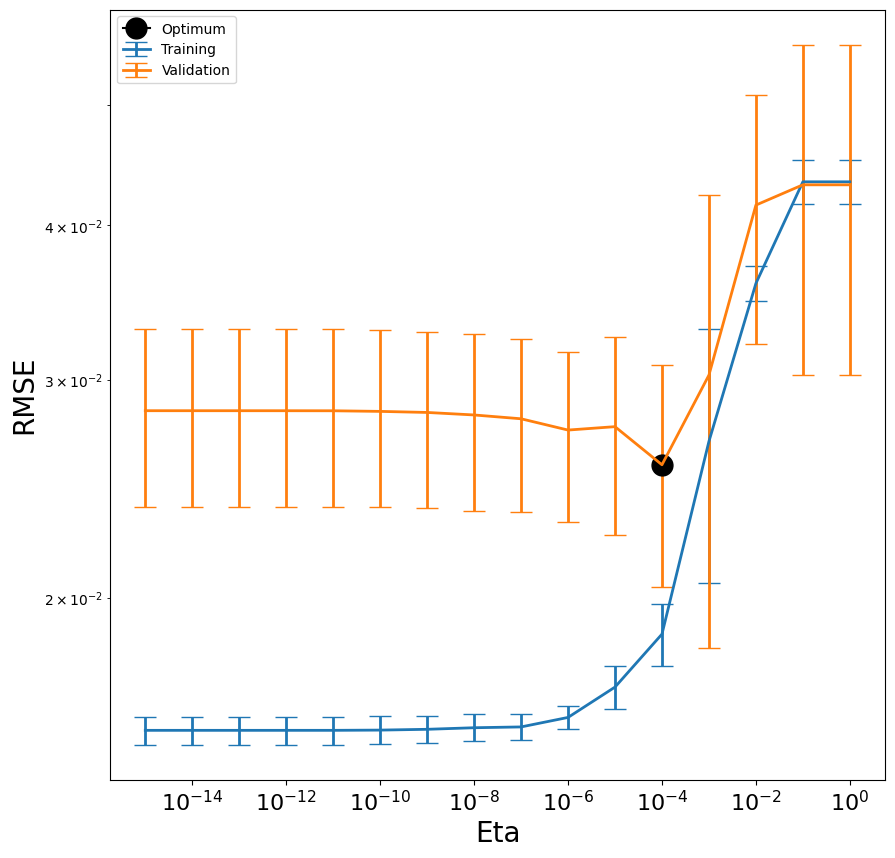

In [17]:
# We first create a list of possible etas to pass in: [1e-16, 1e-15, ... , 1e-2, 1e-1, 1]
etas = 1/np.power(10,[i for i in range(0,16)])

# Then, we call the function to choose the optimal eta:
eta_opt = optimize_eta(pce_surr, etas, 10, verbose = True, plot=True)

From our eta plot above, we can see that our most optimal eta falls at $1 \times 10^{-4}$, where the validation error is the lowest. While this indicates that the model performs well at this eta value, we can still observe a tendency towards overfitting in the model. For larger eta values, the training and validation RMSE lines are close together, suggesting that the model is performing similarly on both seen and unseen datasets, as would be desired. However, as eta decreases, the training RMSE falls while the validation RMSE rises, highlighting a region where overfitting occurs. 

This behavior is expected because smaller eta values retain more basis terms, increasing the model's degrees of freedom. While this added flexibility allows the model to fit the training data more closely, it also makes the model more prone to fitting noise rather than capturing the true underlying function. Selecting the most optimal eta of $1 \times 10^{-4}$, as compared to the earlier user-defined eta of $1 \times 10^{-10}$, allows us to balance model complexity and generalization.

Now, with the most optimal eta obtained, we can run the fitting again and produce parity plots for our predicted output.

In [18]:
# Build the linear regression object for fitting
pce_surr.build(regression='bcs', eta=eta_opt)

# Optional verbosity output:
print("Retained Basis and Coefficients:")
pce_surr.pcrv.printInfo()
print("Number of retained basis terms:", pce_surr.get_pc_terms())

Regression method: bcs
Retained Basis and Coefficients:
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [2 0 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [2 1 0 0]] [-0.62783727 -0.37134989 -0.08735439 -0.02919352  0.0480559  -0.03471433
  0.0232746   0.0196456 ]
Number of retained basis terms: [8]


In [19]:
# Evaluate the PC model with training and testing data
y_trn_approx = pce_surr.evaluate(value_ksi_trn)
y_tst_approx = pce_surr.evaluate(value_ksi_tst)

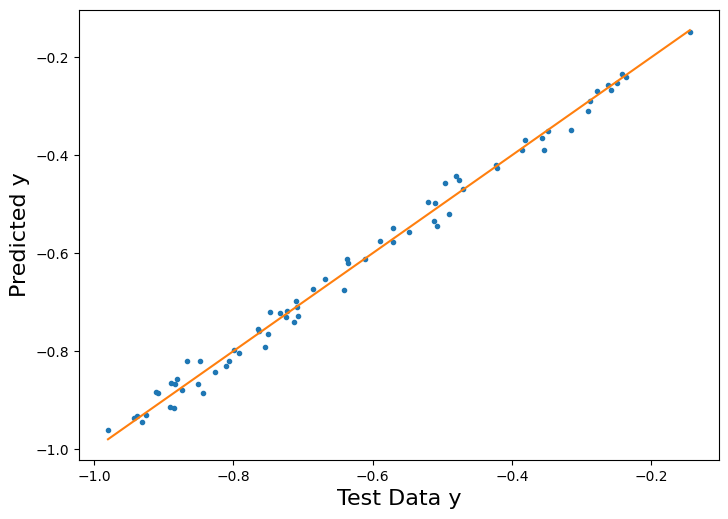

In [20]:
# Plot the surrogate model's output vs. the testing data output
y_tst_mM = [y_trn[:,0].min(),y_trn[:,0].max()]

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_axes([0.15, 0.15, 0.80, 0.75])

ax2.plot(y_trn[:,0],y_trn_approx["Y_eval"],".")
ax2.plot(y_tst_mM,y_tst_mM) # Diagonal line

ax2.set_xlabel("Test Data y", size=16)
ax2.set_ylabel("Predicted y", size=16); 

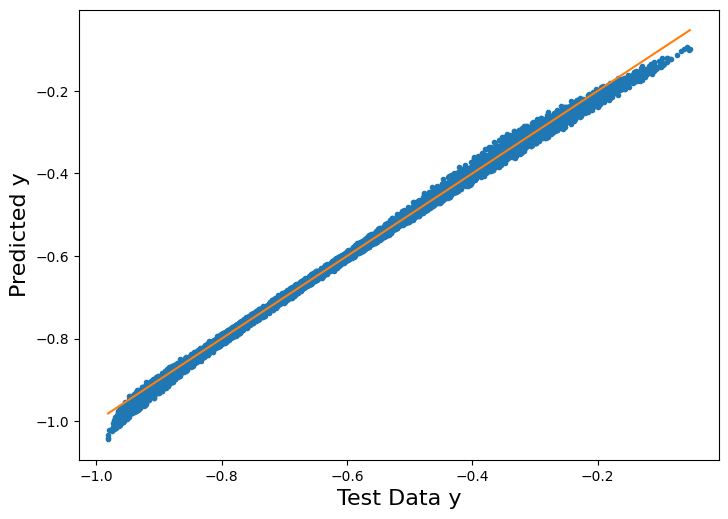

In [21]:
# Plot the surrogate model's output vs. the testing data output
y_tst_mM = [y_tst[:,0].min(),y_tst[:,0].max()]

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_axes([0.15, 0.15, 0.80, 0.75])

ax2.plot(y_tst[:,0],y_tst_approx["Y_eval"],".")
ax2.plot(y_tst_mM,y_tst_mM) # Diagonal line

ax2.set_xlabel("Test Data y", size=16)
ax2.set_ylabel("Predicted y", size=16); 

In [22]:
# Evaluate goodness of fit with RMSE
rmse_trn = root_mean_squared_error(y_trn[:,0],y_trn_approx["Y_eval"])
print("The training RMSE in the PCE BCS approximation is %.2e"%rmse_trn)

rmse_tst = root_mean_squared_error(y_tst[:,0],y_tst_approx["Y_eval"])
print("The testing RMSE in the PCE BCS approximation is %.2e"%rmse_tst)

The training RMSE in the PCE BCS approximation is 2.02e-02
The testing RMSE in the PCE BCS approximation is 1.21e-02


In these final RMSE calculations, we can see how our training RMSE has decreased from 1.80e-02 to 1.21e-02 by building with the most optimal eta. This indicates that our model has improved in generalization and is performing better on unseen data. Though our training error is still larger than our testing error, this can be attributed to the lack of noise in our testing data, while noise is present in our training data. While the optimal eta reduces overfitting and improves generalization, the noise in our training data still impacts the training error and remains an important consideration during our evaluation of the model performance.